In [1]:
import os
import pandas as pd
from textblob import *
import nltk
import numpy as np
import openpyxl
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import *
'''
    WELFAKE
'''



data = pd.read_csv(r"../data/Des_fake_news/WELFAKE_PROCESSED.csv")
data["flag"] = data["label"]
data = data.sample(100)
data



,Unnamed: 0.1,Unnamed: 0,title,text,label,text_tb_pol,text_tb_sub,title_tb_pol,title_tb_sub,title_vader_comp,title_vader_neg,title_vader_neu,title_vader_pos,text_vader_neg,text_vader_neu,text_vader_pos,flag
4686,52169,52169,ITS A WAR Armed Illegal Aliens Are Running Far...,Farmers and ranchers are being run off their ...,1,0.081560,0.513870,-0.162500,0.687500,-0.9529,0.487,0.513,0.000,0.081,0.857,0.062,1
3290,4487,4487,Re Undoubtedly Hillary loves having support ...,Magnus Dahlgren MagnusDahlgren October ...,1,0.200000,0.406667,0.200000,0.300000,0.7506,0.000,0.584,0.416,0.043,0.787,0.170,1
377,11988,11988,Katy Perry Cher Join Anti Trump Womens March ...,Singers Katy Perry and Cher will be among the ...,0,0.024166,0.409969,0.000000,0.000000,-0.0258,0.184,0.640,0.176,0.066,0.842,0.091,0
822,32035,32035,Democratic senator opposes spending bill over ...,WASHINGTON Reuters Democratic U S Senator...,0,-0.055000,0.535000,0.000000,0.000000,0.2500,0.105,0.724,0.171,0.042,0.851,0.106,0
684,27306,27306,Senators question Goldman Sachs on its role in...,Reuters Two U S senators are seeking deta...,0,0.023611,0.228704,0.000000,0.000000,0.0000,0.000,1.000,0.000,0.040,0.925,0.036,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2806,47819,47819,Ikea Reaches Million Settlement Over Deadly ...,Ikea has reached a tentative settlement to pay...,0,0.037281,0.348183,-0.031818,0.427273,-0.2732,0.170,0.741,0.089,0.090,0.839,0.071,0
3718,51143,51143,Oregon Man Accused of Trying to Shove Co Worke...,An Oregon man who worked for a tree service co...,0,-0.073333,0.130556,0.000000,0.000000,-0.2960,0.167,0.833,0.000,0.136,0.864,0.000,0
1247,46752,46752,GREAT TRUMP VIDEO ON INSTAGRAM NOT ON MY WATCH,You can say what you want to about Trump but t...,1,0.148611,0.583333,0.800000,0.750000,0.6249,0.000,0.661,0.339,0.000,0.855,0.145,1
2582,38470,38470,Trump to nominate Robert Jackson for seat on S...,WASHINGTON Reuters U S President Donald T...,0,0.009596,0.359764,-0.100000,0.600000,0.0000,0.000,1.000,0.000,0.025,0.931,0.043,0


In [2]:
'''
    Add tf-idf vectorizer
'''

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import pandas as pd

def tf_idf_vectorize(df: pd.DataFrame, corpus: pd.Series, vocabulary: list[str]) -> tuple[list[str], pd.DataFrame]:
    stop_words = stopwords.words("english")
    vectorizer = TfidfVectorizer(strip_accents="ascii", lowercase=True, stop_words=stop_words, max_features=500, ngram_range=(1,3), vocabulary=vocabulary)
    features = vectorizer.fit_transform(corpus).toarray()
    names = vectorizer.get_feature_names_out()
    headers = [f"__word{i}" for i in range(len(names))]
    feature_frame = pd.DataFrame(features, columns=headers)
    #final = pd.concat([df, feature_frame], axis=1)
    return (names, feature_frame)


def get_full_vocabulary(corpus: pd.Series) -> list[str]:
    vectorizer = TfidfVectorizer(strip_accents="ascii", lowercase=True, stop_words=stopwords.words("english"), max_features=500, ngram_range=(1,3))
    vectorizer.fit_transform(corpus).toarray()
    return vectorizer.get_feature_names_out()


def add_tf_idf_vector(x: pd.DataFrame, partial_corpus: pd.Series, full_corpus: pd.Series) -> pd.DataFrame:
    temp = pd.concat((x, partial_corpus), axis=1).reset_index()
    # first, we need a vocabulary from the entire dataset
    vocabulary = get_full_vocabulary(full_corpus)

    tf_idf_vector = tf_idf_vectorize(temp, temp[partial_corpus.name], vocabulary=vocabulary)[1].reset_index()
    temp = temp.reset_index()
    temp = pd.concat((temp, tf_idf_vector), axis=1).drop([partial_corpus.name, "index"], axis=1)
    return temp



In [3]:
from openpyxl import load_workbook, Workbook

'''
    Define filtered dataset, classes, features, dataframe for model accuracies, and excel file for results
'''

'''Drop NA'''
filtered = data.dropna()
classes = filtered["flag"]

filtered["corpus"] = filtered.apply(lambda x: " ".join([x["title"], x["text"]]), axis=1)


# raw polarity and subjectivity scores from Textblob, Vader
features = filtered[["text_tb_pol",	"text_tb_sub",	"title_tb_pol",	"title_tb_sub",	"title_vader_comp",	"title_vader_neg",	
              "title_vader_neu",	"title_vader_pos",	"text_vader_neg",	"text_vader_neu",	"text_vader_pos"]]

# dataframe to store accuracies for NN and log regression
#accuracy_df = pd.DataFrame(columns=["polarity",
#               "tfidf",
#               "combined"])


EXCEL_FILE = r"../data/Des_fake_news/Sentiment_Analysis_Results/WELFAKE_RESULTS.xlsx"
# overwrite book if exists
book = Workbook()
book.save(filename=EXCEL_FILE)
book.close()


0
tf_idf training
tf_idf testing
ensemble fitting
1
tf_idf training
tf_idf testing
ensemble fitting
2
tf_idf training
tf_idf testing
ensemble fitting
3
tf_idf training
tf_idf testing
ensemble fitting
4
tf_idf training
tf_idf testing
ensemble fitting
Train accuracy on 5-fold cross-validation: 1.0
Test accuracy on 5-fold cross-validation: 0.78
Average confusion matrix:
[[7.2 2.2]
 [2.2 8.4]]


,train,test
0,1.0,0.78


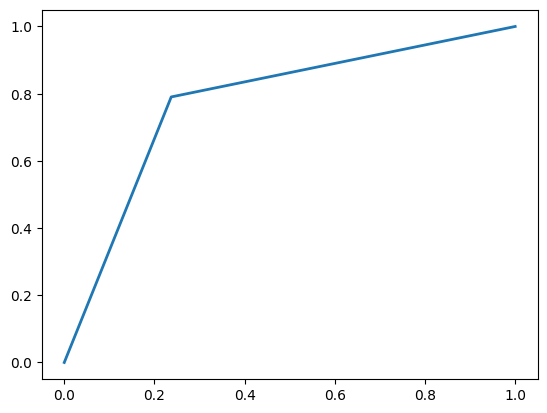

In [ ]:
'''
    POLARITY + TF-IDF
'''
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import KFold
import openpyxl.drawing
from sklearn import metrics
import matplotlib.pyplot as plt
import io



# average accuracies
comb_output = {"train" : None, "test" : None}
comb_matrices = []


comb_fpr = []
comb_tpr = []
comb_thresh = []

comb_auc = 0


train_total = 0
test_total = 0
run_count = 0


#lbgfs
x = features
y = classes
folds = 5
kf = KFold(n_splits=folds)

for i, (train_index, test_index) in enumerate(kf.split(x)):
    print(i)
    scaler = StandardScaler()
    print("tf_idf training")
    x_train = add_tf_idf_vector(x.iloc[train_index], filtered["corpus"].iloc[train_index], filtered["corpus"])
    x_train = scaler.fit_transform(x_train)

    print("tf_idf testing")
    x_test = add_tf_idf_vector(x.iloc[test_index], filtered["corpus"].iloc[test_index], filtered["corpus"])
    x_test = scaler.transform(x_test)
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

    comb_ensemble = VotingClassifier(estimators=[
    ('lr', LogisticRegression(max_iter=500)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svc', SVC(kernel='rbf', probability=True, random_state=42))
    ], voting='soft')
    print("ensemble fitting")
    comb_ensemble.fit(x_train, y_train)
    y_pred = comb_ensemble.predict(x_test)

    fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred, pos_label=1)
    comb_fpr.append(fpr)
    comb_tpr.append(tpr)
    comb_thresh.append(thresh)
    comb_auc += metrics.auc(fpr, fpr)

    comb_matrices.append(confusion_matrix(y_test, y_pred))
    test_total += accuracy_score(y_test, y_pred)

    y_train_pred = comb_ensemble.predict(x_train)
    train_total += accuracy_score(y_train, y_train_pred)

    run_count += 1

print(f"Train accuracy on {folds}-fold cross-validation: {train_total / float(run_count)}")
print(f"Test accuracy on {folds}-fold cross-validation: {test_total / float(run_count)}")

comb_output["test"] = [(test_total / run_count)]
comb_output["train"] = [(train_total / run_count)]
comb_output = pd.DataFrame(comb_output)

print("Average confusion matrix:")
comb_matrices = np.mean(np.array(comb_matrices), axis=0)
print(comb_matrices)


comb_fpr = np.mean(np.array(comb_fpr), axis=0)
comb_tpr = np.mean(np.array(comb_tpr), axis=0)
comb_thresh = np.mean(np.array(comb_thresh), axis=0)

comb_auc = comb_auc / float(run_count)










comb_output

0
ensemble fitting
1
ensemble fitting
2
ensemble fitting
3
ensemble fitting
4
ensemble fitting
Train accuracy on 5-fold cross-validation: 0.9125
Test accuracy on 5-fold cross-validation: 0.78
Average confusion matrix:
[[7.2 2.2]
 [2.2 8.4]]


,train,test
0,0.9125,0.78


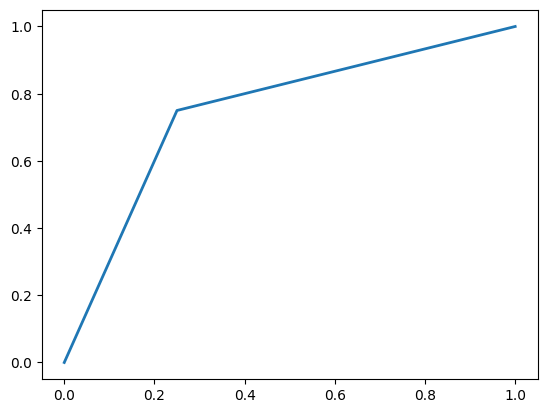

In [ ]:
'''
    POLARITY
'''
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import KFold


# average accuracies
pol_output = {"train" : None, "test" : None}
pol_matrices = []


pol_fpr = []
pol_tpr = []
pol_thresh = []

pol_auc = 0

train_total = 0
test_total = 0
run_count = 0


#lbgfs
x = features
y = classes
folds = 5
kf = KFold(n_splits=folds)

for i, (train_index, test_index) in enumerate(kf.split(x)):
    print(i)
    scaler = StandardScaler()
  
    x_train = x.iloc[train_index]
    x_train = scaler.fit_transform(x_train)

    x_test = x.iloc[test_index]
    x_test = scaler.transform(x_test)
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

    pol_ensemble = VotingClassifier(estimators=[
    ('lr', LogisticRegression(max_iter=500)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svc', SVC(kernel='rbf', probability=True, random_state=42))
    ], voting='soft')
    print("ensemble fitting")
    pol_ensemble.fit(x_train, y_train)
    y_pred = pol_ensemble.predict(x_test)

    pol_fpr.append(fpr)
    pol_tpr.append(tpr)
    pol_thresh.append(thresh)
    pol_auc += metrics.auc(fpr, tpr)

    pol_matrices.append(confusion_matrix(y_test, y_pred))
    test_total += accuracy_score(y_test, y_pred)

    y_train_pred = pol_ensemble.predict(x_train)
    train_total += accuracy_score(y_train, y_train_pred)

    run_count += 1

print(f"Train accuracy on {folds}-fold cross-validation: {train_total / float(run_count)}")
print(f"Test accuracy on {folds}-fold cross-validation: {test_total / float(run_count)}")

pol_output["test"] = [(test_total / run_count)]
pol_output["train"] = [(train_total / run_count)]
pol_output = pd.DataFrame(pol_output)

print("Average confusion matrix:")
pol_matrices = np.mean(np.array(pol_matrices), axis=0)
print(pol_matrices)

pol_fpr = np.mean(np.array(pol_fpr), axis=0)
pol_tpr = np.mean(np.array(pol_tpr), axis=0)
pol_thresh = np.mean(np.array(pol_thresh), axis=0)

pol_auc = pol_auc / float(run_count)




pol_output

0
tf_idf training
tf_idf testing
ensemble fitting
1
tf_idf training
tf_idf testing
ensemble fitting
2
tf_idf training
tf_idf testing
ensemble fitting
3
tf_idf training
tf_idf testing
ensemble fitting
4
tf_idf training
tf_idf testing
ensemble fitting
Train accuracy on 5-fold cross-validation: 1.0
Test accuracy on 5-fold cross-validation: 0.74
Average confusion matrix:
[[7.2 2.2]
 [3.  7.6]]


,train,test
0,1.0,0.74


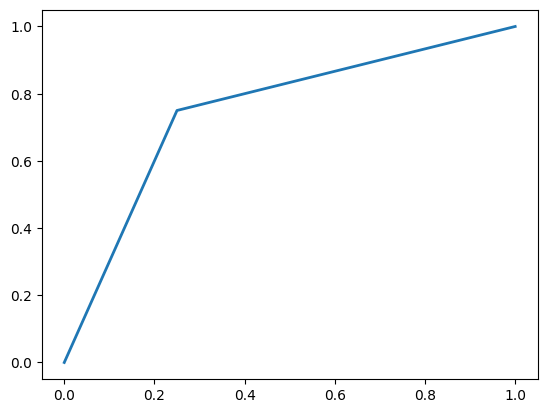

In [ ]:
'''
    TF-IDF
'''
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import KFold


# average accuracies
tf_output = {"train" : None, "test" : None}
tf_matrices = []

train_total = 0
test_total = 0
run_count = 0

tf_fpr = []
tf_tpr = []
tf_thresh = []

tf_auc = 0

#lbgfs
x = features
y = classes
folds = 5
kf = KFold(n_splits=folds)

for i, (train_index, test_index) in enumerate(kf.split(x)):
    print(i)
    scaler = StandardScaler()
    print("tf_idf training")
    x_train = add_tf_idf_vector(x.iloc[train_index], filtered["corpus"].iloc[train_index], filtered["corpus"]).drop(features, axis=1)
    x_train = scaler.fit_transform(x_train)

    print("tf_idf testing")
    x_test = add_tf_idf_vector(x.iloc[test_index], filtered["corpus"].iloc[test_index], filtered["corpus"]).drop(features, axis=1)
    x_test = scaler.transform(x_test)
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

    tf_ensemble = VotingClassifier(estimators=[
    ('lr', LogisticRegression(max_iter=500)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svc', SVC(kernel='rbf', probability=True, random_state=42))
    ], voting='soft')
    print("ensemble fitting")
    tf_ensemble.fit(x_train, y_train)
    y_pred = tf_ensemble.predict(x_test)

    tf_fpr.append(fpr)
    tf_tpr.append(tpr)
    tf_thresh.append(thresh)
    tf_auc += metrics.auc(fpr, tpr)


    tf_matrices.append(confusion_matrix(y_test, y_pred))
    test_total += accuracy_score(y_test, y_pred)

    y_train_pred = tf_ensemble.predict(x_train)
    train_total += accuracy_score(y_train, y_train_pred)

    run_count += 1

print(f"Train accuracy on {folds}-fold cross-validation: {train_total / float(run_count)}")
print(f"Test accuracy on {folds}-fold cross-validation: {test_total / float(run_count)}")

tf_output["test"] = [(test_total / run_count)]
tf_output["train"] = [(train_total / run_count)]
tf_output = pd.DataFrame(tf_output)

print("Average confusion matrix:")
tf_matrices = np.mean(np.array(tf_matrices), axis=0)
print(tf_matrices)

tf_fpr = np.mean(np.array(tf_fpr), axis=0)
tf_tpr = np.mean(np.array(tf_tpr), axis=0)
tf_thresh = np.mean(np.array(tf_thresh), axis=0)

tf_auc = tf_auc / float(run_count)



tf_output

In [8]:
'''
    combine accuracies into one table
'''

final_results = pd.concat((pol_output, tf_output, comb_output), axis=0)
final_results.index = ["Polarity", "Tf-Idf", "Polarity + Tf-Idf"]
final_results

,train,test
Polarity,0.9125,0.78
Tf-Idf,1.0000,0.74
Polarity + Tf-Idf,1.0000,0.78


In [9]:
'''
    Finally, save accuracy metrics to the spreadsheet
'''




book = load_workbook(EXCEL_FILE)
writer = pd.ExcelWriter(EXCEL_FILE, engine="openpyxl")
writer.book = book
final_results.to_excel(writer, sheet_name=f"accuracies")
book.save(filename=EXCEL_FILE)
book.close()



C:\Users\desmo\AppData\Local\Temp\ipykernel_7516\3534906820.py:10: FutureWarning: Setting the `book` attribute is not part of the public API, usage can give unexpected or corrupted results and will be removed in a future version
  writer.book = book


In [11]:
import openpyxl.drawing
from sklearn import metrics
import matplotlib.pyplot as plt
import io


plt.figure()
lw = 2
plt.plot(pol_fpr, pol_tpr,
 lw=lw, label='Polarity: %0.2f)' % pol_auc)
plt.plot(tf_fpr, tf_tpr,
 lw=lw, label='Tf-Idf: %0.2f)' % tf_auc)
plt.plot(comb_fpr, comb_tpr,
 lw=lw, label='Polarity + Tf-Idf: (%0.2f)' % comb_auc)
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
#plt.show()


# save figure as PNG
png = io.BytesIO()
plt.savefig(png, format="png")


# write PNG to excel file
book = load_workbook(EXCEL_FILE)
ws = book.active

img = openpyxl.drawing.image.Image(png)
img.anchor = "A1"
ws.add_image(img)
book.save(filename=EXCEL_FILE)
plt.close()
book.close()



In [ ]:
unique, counts = np.unique(y_test, return_counts=True)
counts[0] / sum(counts)